# ***ConsensusCluster*** *R* Package Tutorial

## 1. Instaltion

In [ ]:
# Install from CRAN
install.packages("ConsensusCluster")

# Insall from GitHub
devtools::install_git("")

In [9]:
# Load library
library(ConsensusCluster)

## 2. Data perturbation consensus clustering (DPCC)
Here we implement consensus clustering (CC) methods used in *Monti et al. (2003)* and *Senbabaoglu at al. (2014)*.
These methods calculate a *stability score* to determine the number of clusters.

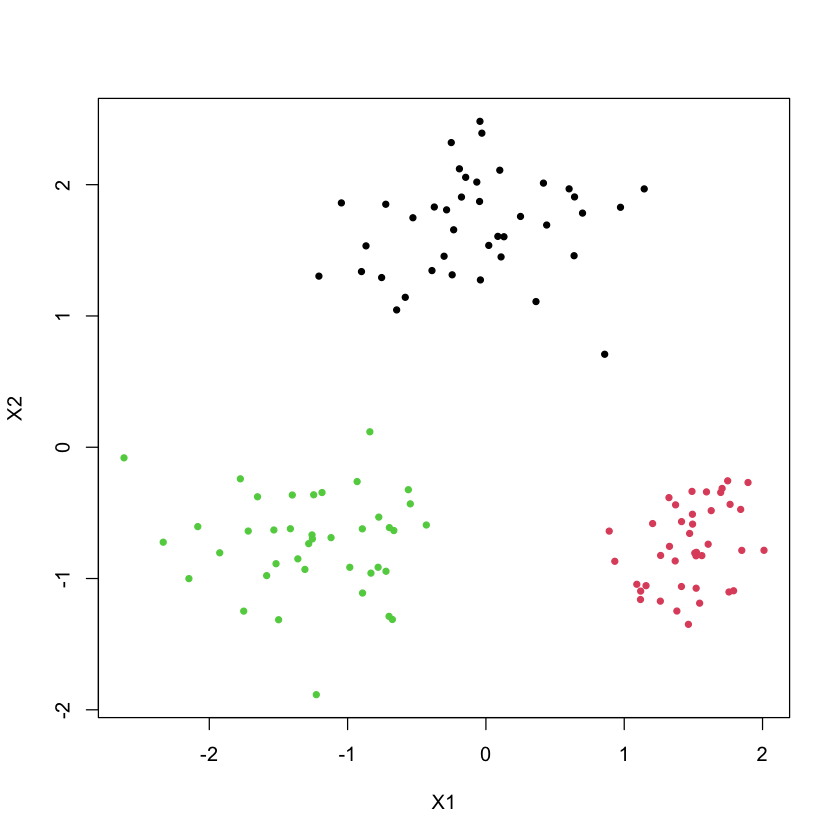

In [46]:
# Generate toy data

set.seed(111)
dim  = 2
data = gaussian_clusters(n = c(40,40,40), dim = dim, sd.max = .5, sd.noise = 0, r.range = c(1,2))
X = data$X
class = data$class
plot(X, pch = 20, col = class, cex = 1)


In [47]:
# Calculate the adjacency matrix (as the algorithm requires a similarity matrix)

Adj = adj_mat(X, method = "euclidian")

In [48]:
# Generation mechanism and calculate consensus matrix

CM = consensus_matrix(Adj, max.cluster = 5, resample.ratio = 0.7, max.itter = 50, clustering.method = "hclust")


[1] "Algorithm Starts...!"
[1] "Number of clusters: 2"
  |======================================================================| 100%
[1] "Number of clusters: 3"
  |======================================================================| 100%
[1] "Number of clusters: 4"
  |======================================================================| 100%
[1] "Number of clusters: 5"
  |======================================================================| 100%


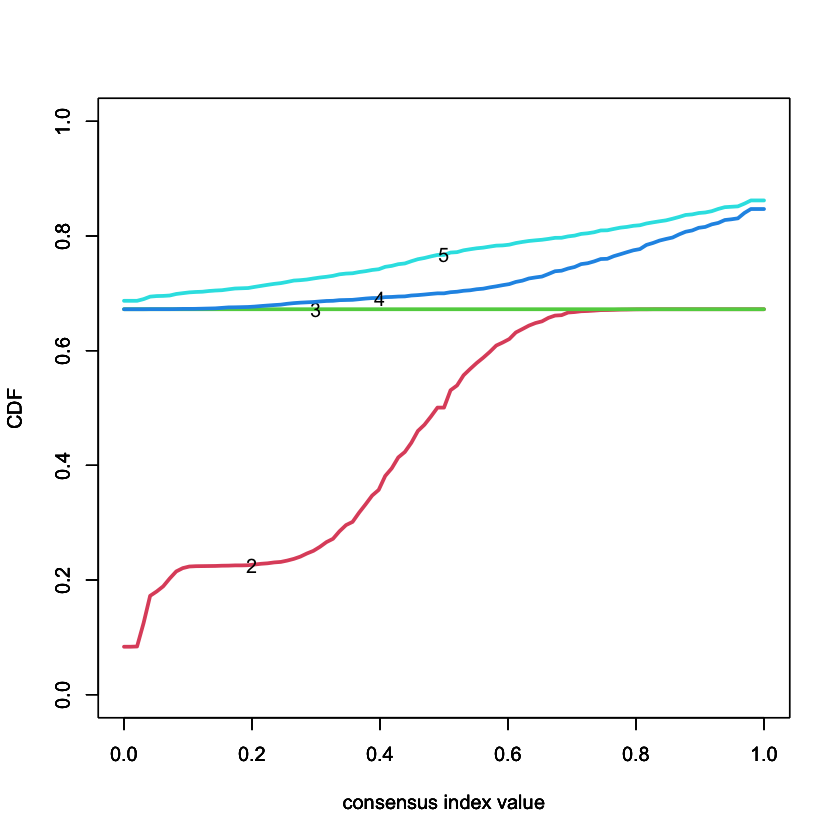

In [49]:
# Calculate stability score and determine the optimum number of clusters

Scores = CC_cluster_count(CM)
RobScore = Scores[["LogitScore"]]


The optimum number of clusters = 3



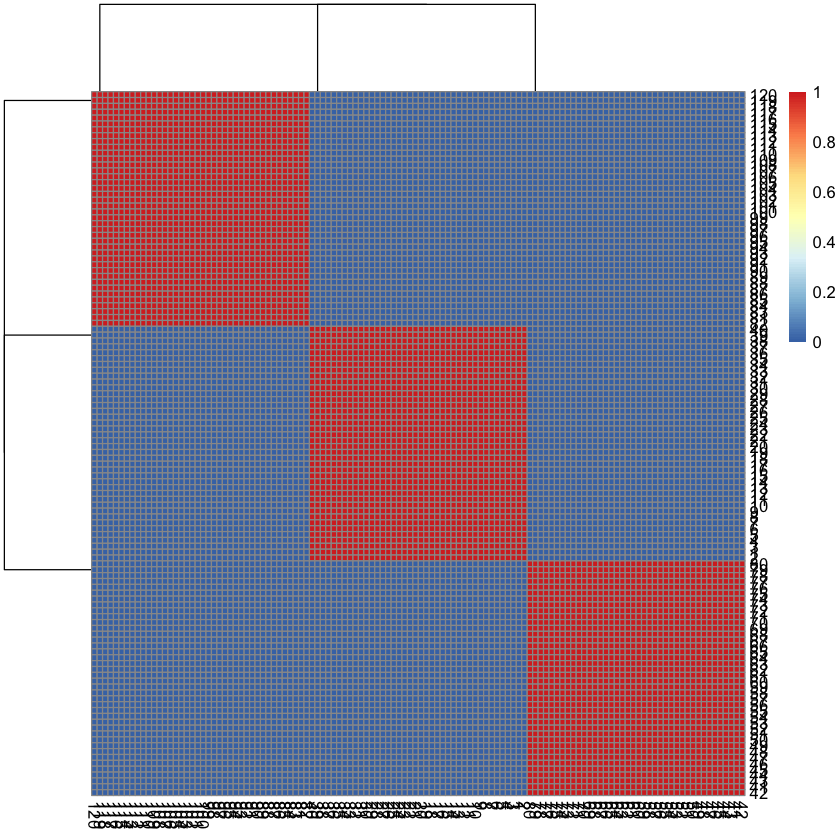

In [50]:

Kopt = Scores[["Kopt_LogitScore"]]
message(paste0("The optimum number of clusters = ", Kopt))

pheatmap::pheatmap(CM[[Kopt]])


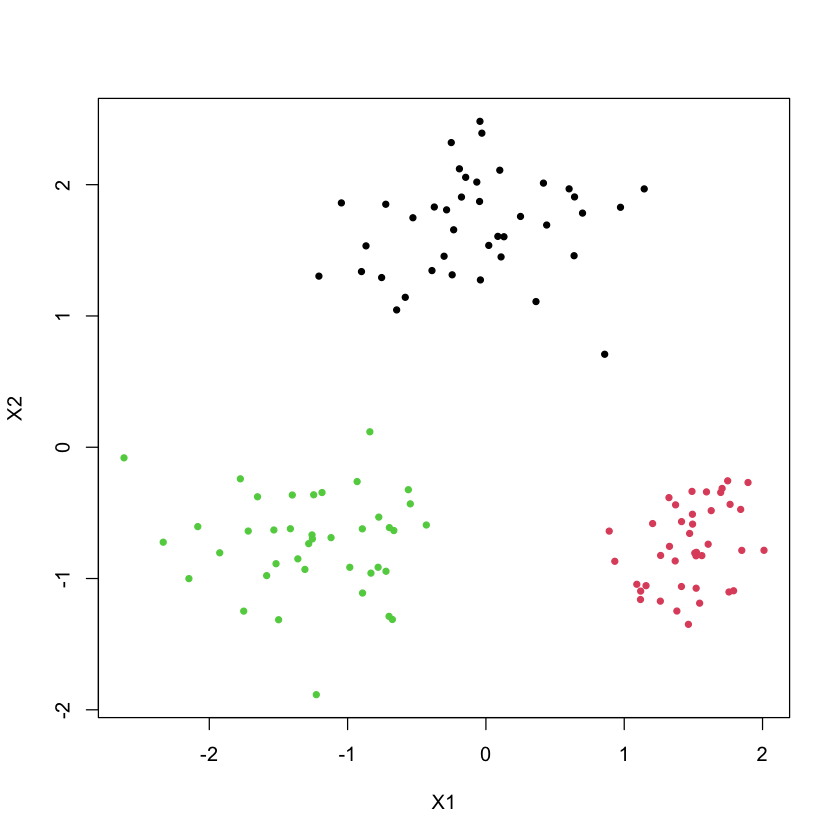

In [52]:
# Clustering consensus matrix

clusters = hir_clust_from_adj_mat(CM[[Kopt]], k = Kopt, alpha = 1, adj.conv = FALSE)
# clusters = spect_clust_from_adj_mat(Adj, k = Kopt, max.eig = Kopt, alpha = 1, adj.conv = TRUE)
# clusters = pam_clust_from_adj_mat(CM[[Kopt]], k = 2, alpha = 1, adj.conv = TRUE)

plot(X[,1:2], pch = 20, col = clusters, cex = 1)

## 3. Method perturbation consensus clustering (MPCC)
Here we implement consensus clustering (CC) methods used in that involve diffeent methods or hyperparameters.
As for consensus mechanism, we consider two methods:
- **consensus matrix** that can optionally use *stability score* to determine the number of clusters.
- **majority voting** that requirs the number of clusters as hyperparameter.

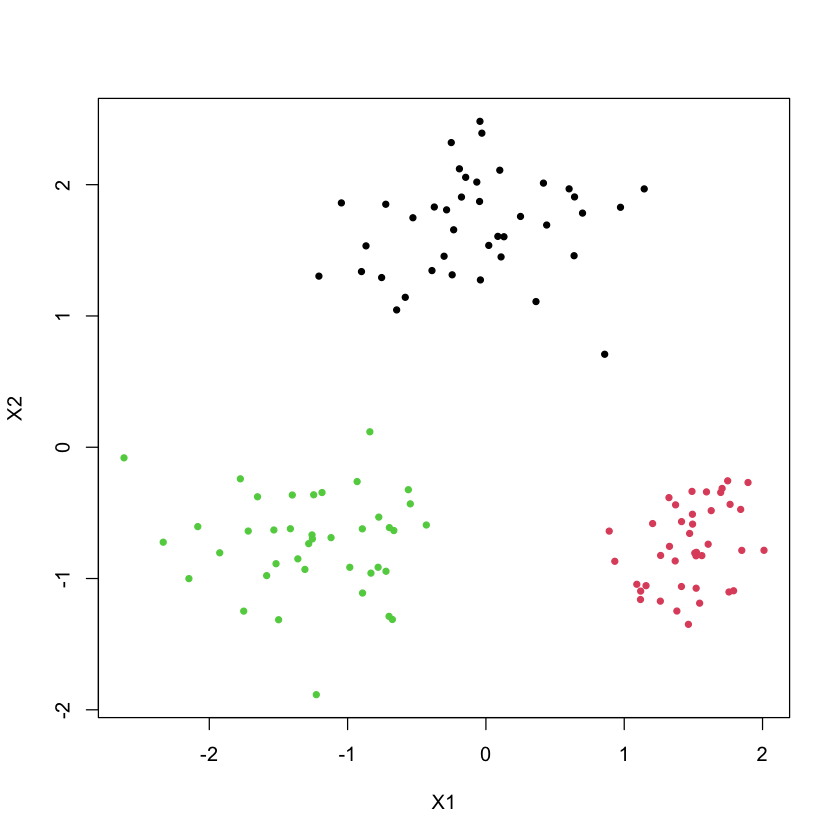

In [89]:
# Generate toy data

set.seed(111)
dim  = 2
data = gaussian_clusters(n = c(40,40,40), dim = dim, sd.max = .5, sd.noise = 0, r.range = c(1,2))
X = data$X
class = data$class
plot(X, pch = 20, col = class, cex = 1)

### 3.1. consensus matrix-based method

In [90]:
# Generation mechanism: obtain different clustering with a various range of k (number of clusters)
# Different methods can be used. Here we consider one method.

Clusters = multi_kmeans_gen(X, rep = 200, range.k = c(2,10), method = "random")
# or
# Clusters = multi_pam_gen(X, rep = 200, range.k = c(2,10), method = "random")

dim(Clusters)

[1] 120 200

  |======================================================================| 100%


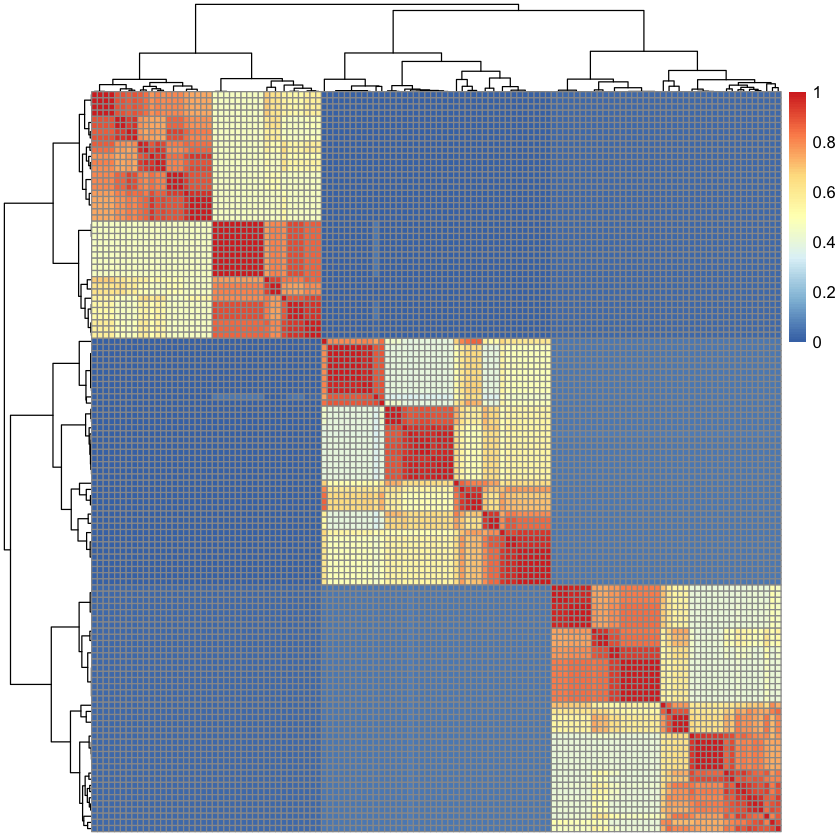

In [91]:
# Consensus mechanism: consensus matrix-based method

CM = coCluster_matrix(Clusters)
pheatmap::pheatmap(CM)

In [92]:
# (Optional) use MDCCC to obtain the number of clusters

CM_dpcc = consensus_matrix(CM, max.cluster = 5, resample.ratio = 0.7, max.itter = 50, clustering.method = "hclust")


[1] "Algorithm Starts...!"
[1] "Number of clusters: 2"
  |======================================================================| 100%
[1] "Number of clusters: 3"
  |======================================================================| 100%
[1] "Number of clusters: 4"
  |======================================================================| 100%
[1] "Number of clusters: 5"
  |======================================================================| 100%


The optimum number of clusters = 3



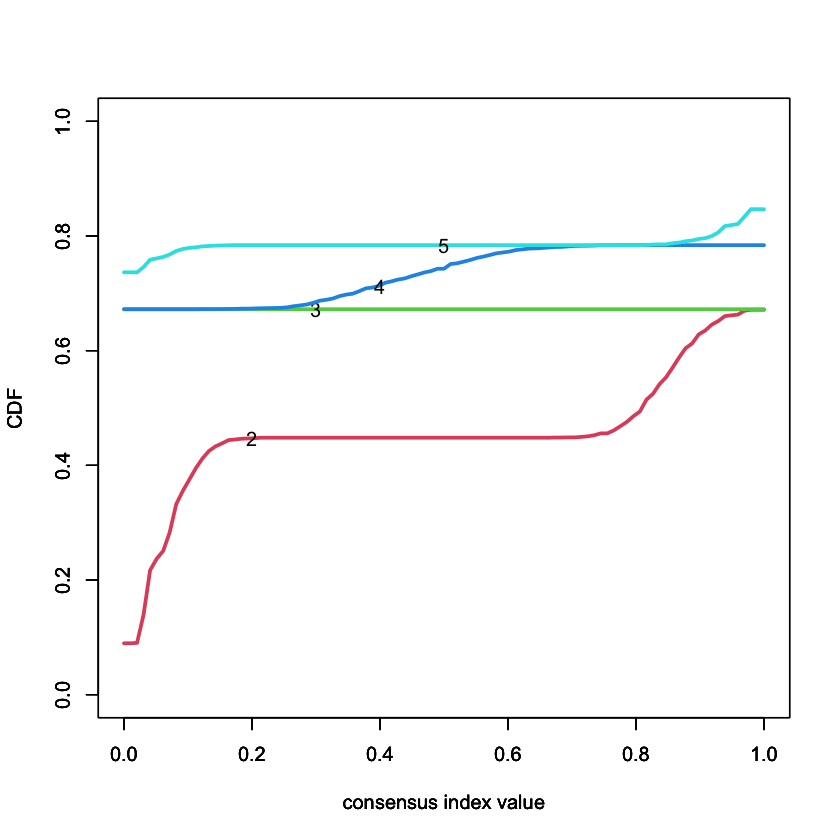

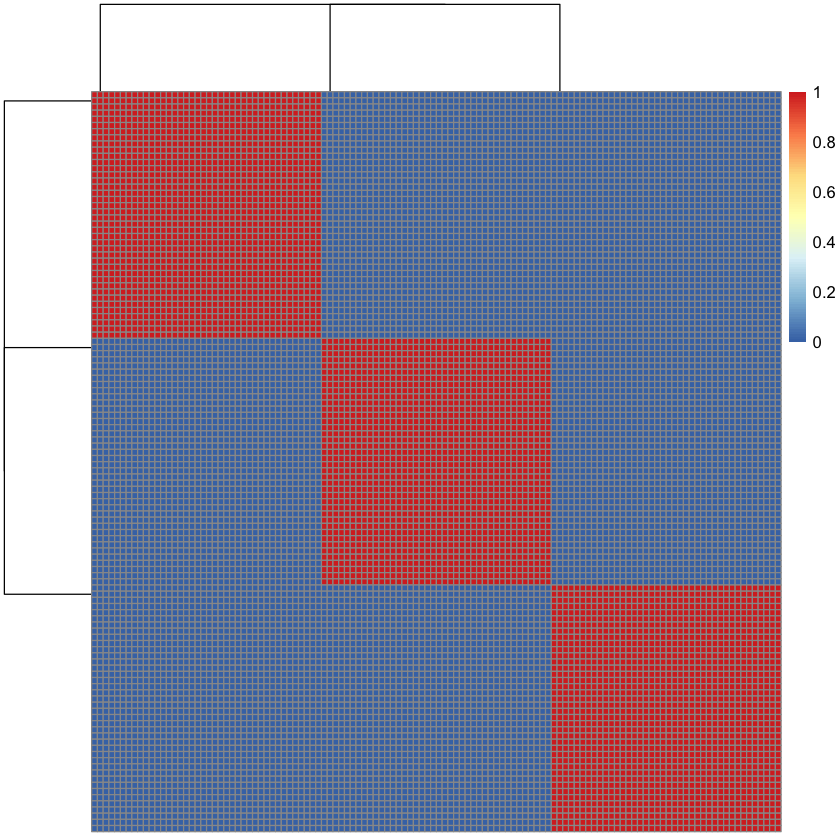

In [93]:
Scores = CC_cluster_count(CM_dpcc)
RobScore = Scores[["LogitScore"]]
Kopt = Scores[["Kopt_LogitScore"]]
message(paste0("The optimum number of clusters = ", Kopt))

pheatmap::pheatmap(CM_dpcc[[Kopt]])

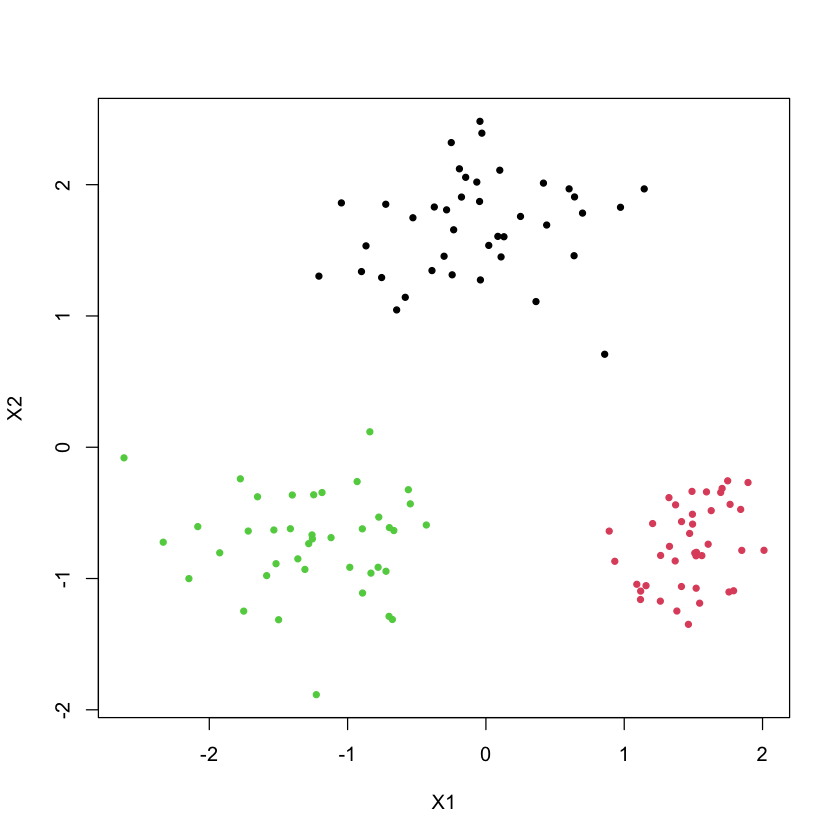

In [72]:
# Final clustering

clusters = hir_clust_from_adj_mat(CM[[Kopt]], k = Kopt, alpha = 1, adj.conv = FALSE)
# clusters = spect_clust_from_adj_mat(Adj, k = Kopt, max.eig = Kopt, alpha = 1, adj.conv = TRUE)
# clusters = pam_clust_from_adj_mat(CM[[Kopt]], k = 2, alpha = 1, adj.conv = TRUE)

plot(X, pch = 20, col = clusters, cex = 1)

### 3.2. Majority voting method

In [80]:
# Generation mechanism: obtain different clustering three different methods

Adj = adj_mat(X, method = "euclidian")

clusters1 = hir_clust_from_adj_mat(Adj, k=3)
clusters2 = spect_clust_from_adj_mat(Adj, k=3)
clusters3 = pam_clust_from_adj_mat(Adj, k=3)

Clusters = cbind(clusters1, clusters2, clusters3)
print(head(Clusters))

  clusters1 clusters2 clusters3
1         1         2         1
2         1         2         1
3         1         3         1
4         1         2         1
5         1         3         1
6         1         2         1


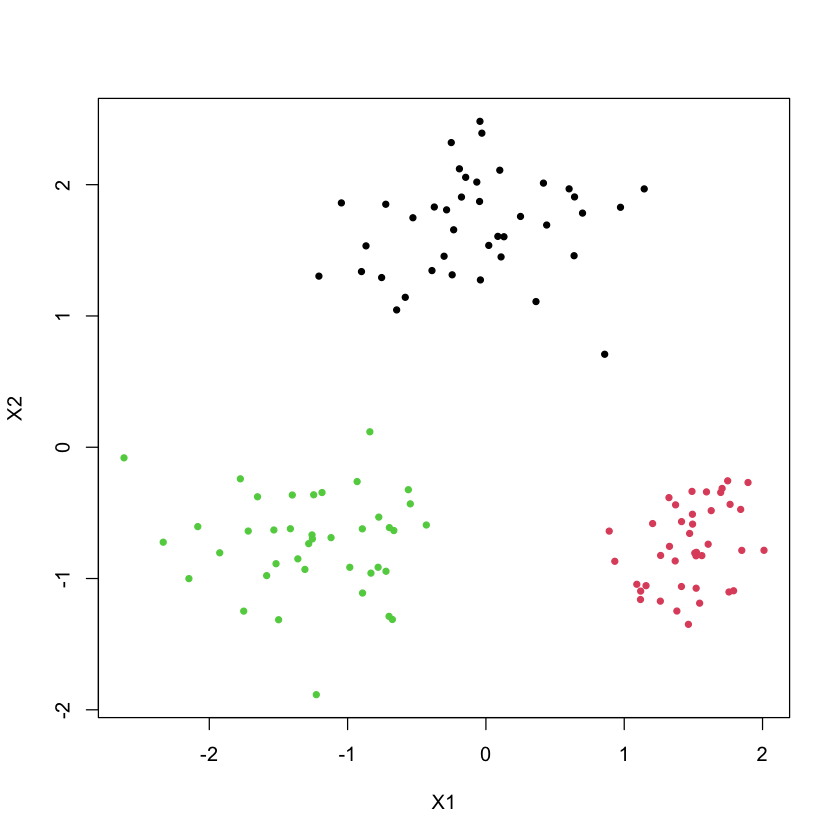

In [82]:
# Consensus mechanism: majority voting

clusters = majority_voting(Clusters)
plot(X, pch = 20, col = as.numeric(clusters), cex = 1)

## 4. Multi-Data consensus clustering (MDCC)
Here we implement consensus clustering (CC) methods used in that involve diffeent data sets either *multi-cohort clustering* or *multi-view clustering*.

We consider two mwthods:
- MDCC based on DPCC: each data view is considered as a perturbed version of the hidden state.
- MDCC based on MPCC: perform MPCC on each view and then aggregate.

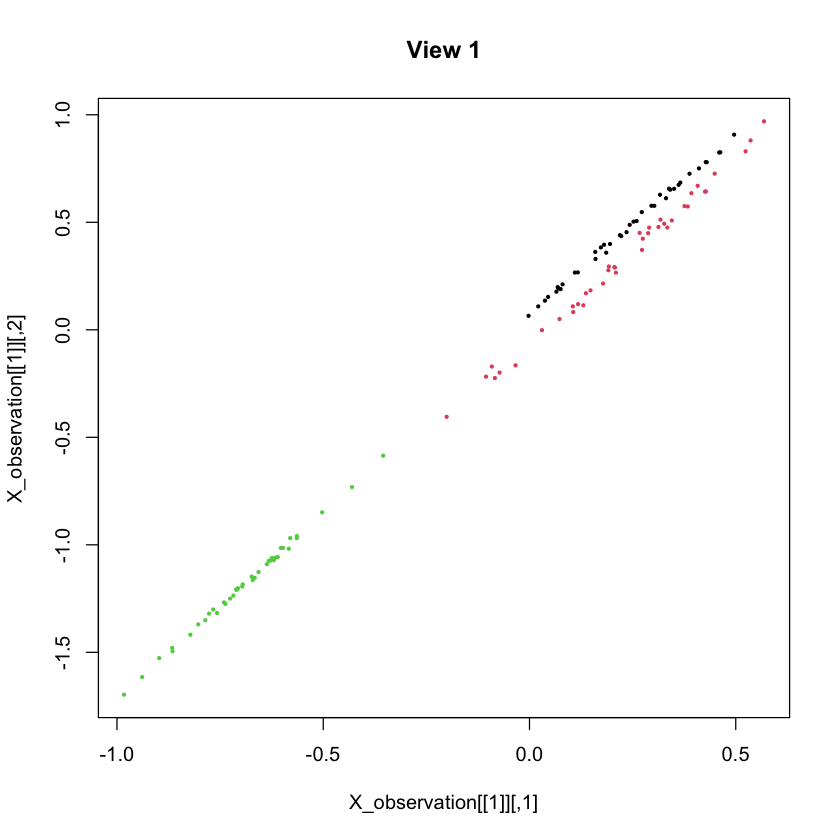

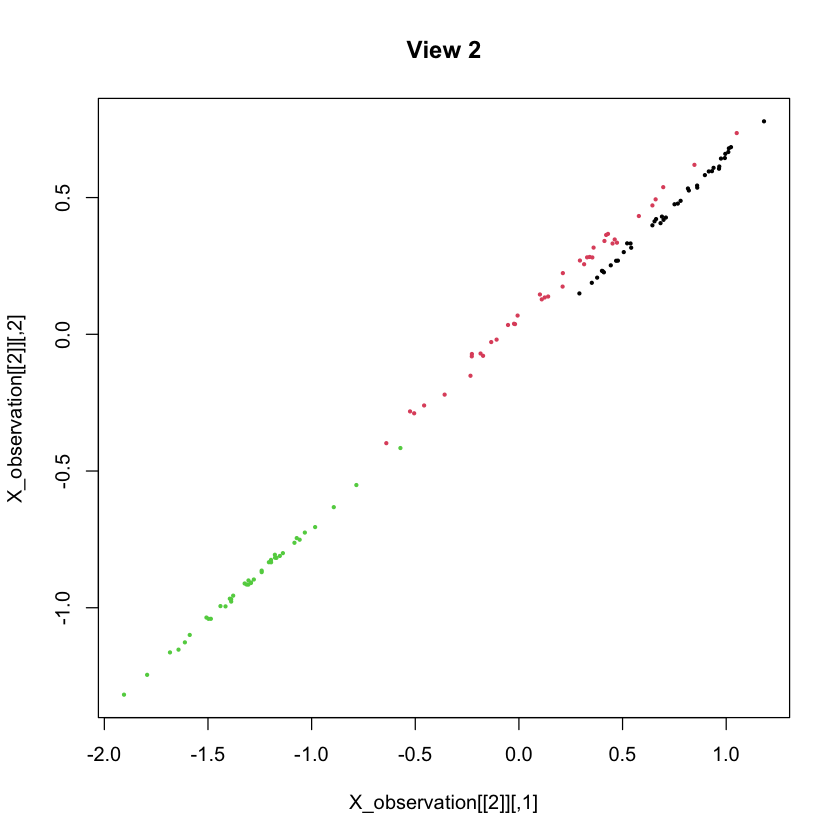

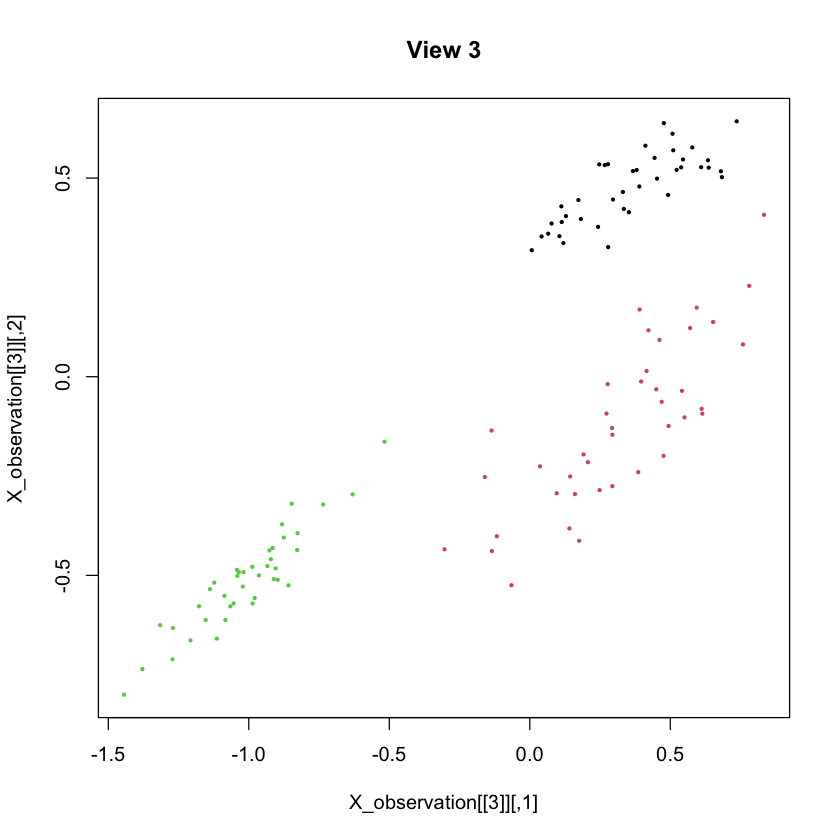

In [105]:
# Generate toy data

set.seed(333)

data = multiview_clusters (n = c(40,40,40), hidden.dim = 2, observed.dim = c(2,2,2),
                           sd.max = .1, sd.noise = 0, hidden.r.range = c(.5,1))

X_observation = data[["observation"]]
X_hidden = data[["hidden"]]
class = data[["class"]]

# plot(X_hidden, pch = 20, col = class, cex = .5)
plot(X_observation[[1]], pch = 20, col = class, cex = .5, main = "View 1")
plot(X_observation[[2]], pch = 20, col = class, cex = .5, main = "View 2")
plot(X_observation[[3]], pch = 20, col = class, cex = .5, main = "View 3")

### 4.1. MDCC based on DPCC
This method may not be an approperitae choice when there are few number of datasets.

[1] "Algorithm Starts...!"
[1] "Number of clusters: 2"
  |======================================================================| 100%
[1] "Number of clusters: 3"
  |======================================================================| 100%
[1] "Number of clusters: 4"
  |======================================================================| 100%
[1] "Number of clusters: 5"
  |======================================================================| 100%


The optimum number of clusters = 3



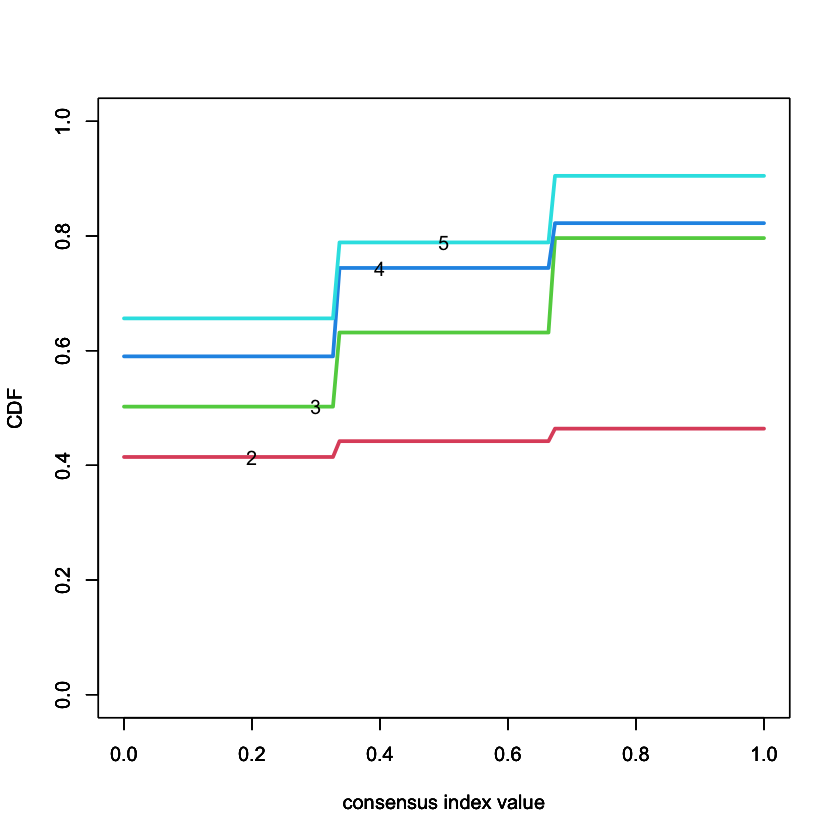

In [106]:
Adj = list()
for (i in 1:length(X_observation)){
  Adj[[i]] = adj_mat(X_observation[[i]], method = "euclidian")
}

CM = multiview_consensus_matrix(Adj, max.cluster = 5, clustering.method = "hclust")

Scores = CC_cluster_count(CM)
K_opt = Scores[["Kopt_LogitScore"]]
message(paste0("The optimum number of clusters = ", Kopt))

  |======================================================================| 100%


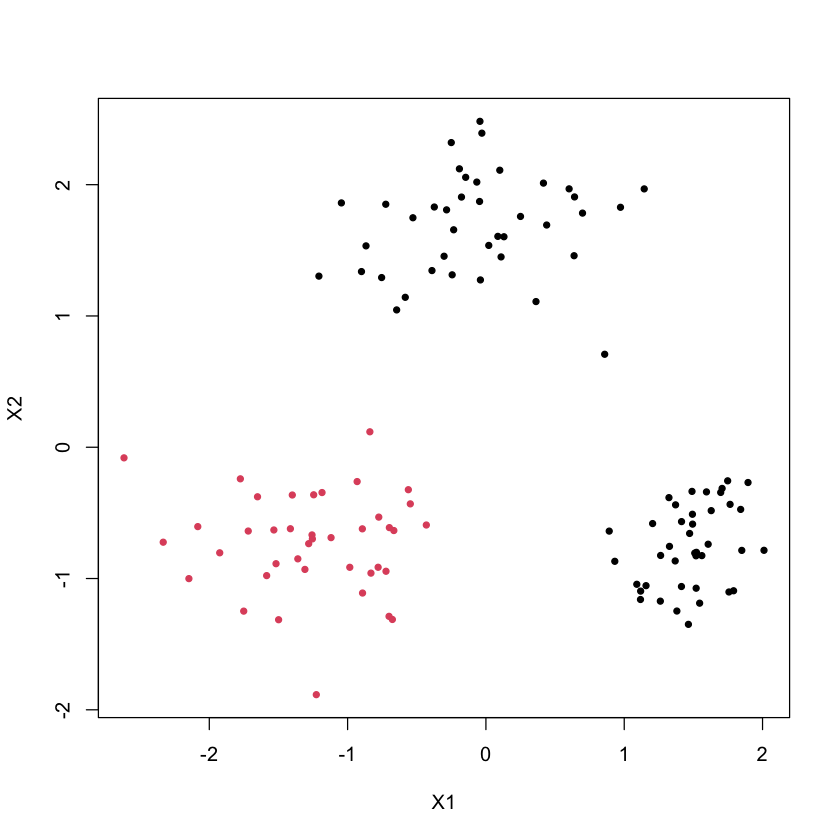

In [108]:
### 4.2. MDCC based on MPCC

# Clusters = multiview_kmeans_gen(X_observation, rep = 100, range.k = c(5,20), method = "random")
Clusters = multiview_pam_gen(X_observation, rep = 100, range.k = c(5,20), method = "random")

Adj = coCluster_matrix(Clusters)

clusters = pam_clust_from_adj_mat(Adj, k = 2, alpha = 1, adj.conv = TRUE)
plot(X, pch = 20, col = clusters, cex = 1)